In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from operator import itemgetter
import sklearn.decomposition
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

### General helper functions

In [2]:
# Loading data and transforming it to pandas dataframe
def load_data(path, col_name):
    data = sio.loadmat(path)
    data = pd.DataFrame(data['Y'])
    return data

In [3]:
# Plot the data
def plotClusterOutput(Y, x1, x2):
    f1 = np.ravel(Y[x1, :])
    f2 = np.ravel(Y[x2, :])
    plt.scatter(f1, f2, c='blue', s=7)
    plt.show()

def plot_data(X, data_centers):
   
    # Add cluster centers to data points
    C = np.matrix(data_centers).T
    X = np.hstack((X, C))
    data = pd.DataFrame(X, columns=['x1', 'x2', 'c'])
   
    fig, ax = plt.subplots(figsize=(12,8))
   
    # Draw the plots
    ax.scatter(data.x1, data.x2, label='Data', c=data.c * 10)
   
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')

### Helper functions for K-means

In [4]:
# Assigns each data point to a centroid
def assignment(X, centroids):
    C = dict.fromkeys(range(X.shape[0]), np.inf)
    Z = {}
    for i in centroids.keys():
        for j in range(X.shape[0]):
            
            # Euclidean dist
            dist = abs(np.linalg.norm(X[j] - centroids[i]))
            
            # Change assignment if dist is lesser than previous
            if dist < C[j]:
                C[j] = dist
                Z[j] = i
    return Z

In [5]:
# Updates the centroids 
def update(centroids, X, Z):
    for i in centroids.keys():
        temp = []
        for j in range(X.shape[0]):
            if Z[j] == i:
                temp.append(X[j])
        centroids[i] = np.mean(temp, axis=0)
    return centroids

In [6]:
# Computes the cost after new centroid assignment
def compute_cost(centroids, X, Z):
    cost = 0
    for i in centroids.keys():
        temp = []
        for j in range(X.shape[0]):
            if Z[j] == i:
                temp.append(X[j])
                
        for k in range(len(temp)): 
            cost += abs(np.linalg.norm(temp[k] - centroids[i]))
    return cost

### K-means

In [7]:
def k_means(X, k, r):
    # Initialize metadata
    X = X.T
    clustering_run = {}
    tol = 0.00001
    
    # Iterate over given r
    for itr in range(r):
        cost = [np.inf]
        
        # Initialize random centroids
        centroids = {}
        rand = np.random.choice(len(X), k, replace=False)
        for i in range(len(rand)):
            centroids[i] = X[i, :]
        
        # Loop till you converge
        while True:
            # Alternate between assignment and update
            Z = assignment(X, centroids)
            centroids = update(centroids, X, Z)
            new_Z = assignment(X, centroids)
            cost.append(compute_cost(centroids, X, new_Z))
            
            # if change in cost is less than tol the break
            if cost[-2] - cost[-1] == 0:
                break
                
        clustering_run[cost[-1]] = new_Z
        
    return min(clustering_run.items(), key=itemgetter(0))[1]


### Helper functions for Spectral clustering

In [8]:
def generate_W(X):
    X = X.T
    length = X.shape[0]
    W = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            if i!= j:
                W[i][j] = np.exp(-np.linalg.norm(X[i]-X[j], 2)/np.var(X))
    return W

### Specteral Clustering

In [13]:
def spectral(W, k):
    
    # Compute Diagonal matrix D
    D = np.diag(np.sum(W, axis=0))
    
    D = np.matrix(D)
    W = np.matrix(W)
    
    # Compute Laplace matrix L
    L = D - W
    
    lam, V = np.linalg.eig(L)
    
    bottom_eig = lam.argsort()[:k]
    
    V1 = V[bottom_eig[0]].getA1()
    V2 = V[bottom_eig[1]].getA1()
    top_V = np.matrix([V1, V2])
    
    print(top_V.shape)
    print(top_V)
    
    return top_V, k_means(top_V, 2, 5)

### PCA for plotting

In [10]:
# Normalizes the data to get the mean to 0
def normalize_mean(Y):
    mu = Y.mean(0)
    Y = Y - mu
    return Y

def pca(Y, d):
    Y = Y.T

    # Normalize mean
    Y = normalize_mean(Y)

    # Find the correlation matrix
    C = (Y.T * Y) / Y.shape[0]

    # Do eigenvalue decomposition get the
    # eigenvalues(W) and eigenvectors(V) of 
    # covariance matrix
    W, V = np.linalg.eig(C)

    # Extract the top-d eigenvectors
    V = V[:, 0:d]
    
    # Represent data in this basis
    X = Y * V
    
    # Calculate the mean of low-dimensional space
    M_X = np.sum(X, axis=0) / X.shape[0]
    
    return V.T, M_X, X.T

#### MAIN

In [11]:
def main():
    data = load_data("HW3_Data/dataset2.mat", 'Y')
    X = np.matrix(data.values)
    Z = k_means(X, 2, 10)
    output = []
    # Get the output values from Z
    for key in Z:
        output.append(Z[key])
    U, mean, X_pca = pca(X, 2)
    plot_data(X_pca.T, output)
    
    # Spectral Clustering
    W = generate_W(X)
    top_V, Z_s = spectral(W, 2)
    
    
    output = []
    # Get the output values from Z
    for key in Z_s:
        output.append(Z_s[key])
    
    plot_data(X_pca.T, output)
    
    
    
    

(2, 200)
[[  1.74158020e-20  -2.74971036e-18   1.54479708e-20  -6.78118901e-19
    1.18925315e-19   4.82380463e-20  -6.52655881e-20  -5.25058534e-16
    1.14505187e-19  -2.31197682e-20  -1.58143983e-19  -1.78949804e-17
   -1.57558745e-19   8.15232970e-19   7.48783030e-21   1.06414148e-21
    1.16878552e-20   8.13635079e-19  -5.67809997e-17   6.43441286e-15
   -4.61781422e-19  -1.32986126e-19   1.40936596e-20   2.33577612e-19
    3.88782505e-18   2.91819563e-15  -4.25230305e-15   2.84078456e-15
    1.04982632e-15  -1.25952209e-20  -6.46051677e-17   1.38111914e-19
    1.17159045e-20   1.62879149e-19   1.25609844e-17   3.26095040e-18
   -5.71160300e-19  -7.41040287e-16   1.12072736e-14   3.40500215e-19
   -4.71729435e-16   1.84885775e-17   8.01128966e-15  -5.67701330e-19
   -1.09027586e-04   2.89845611e-17  -2.95741552e-16  -1.86679338e-16
   -8.29954302e-03   2.01962591e-16  -6.92012871e-16  -4.59540132e-15
   -1.16885067e-14  -1.33354663e-14   1.25176111e-15  -3.82362489e-15
    5.62736

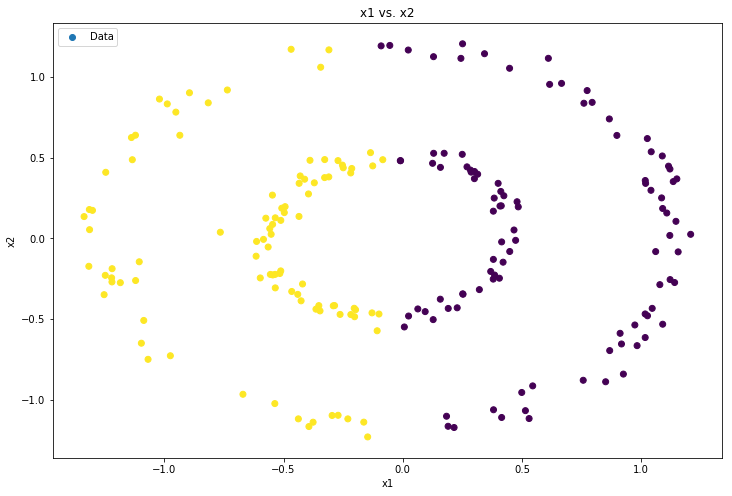

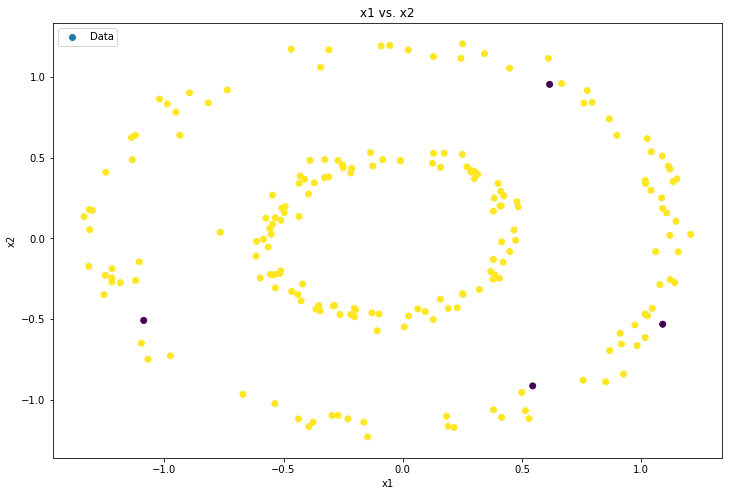

In [12]:
if __name__ == '__main__':
    main()